In [1]:
import os
import pandas as pd
import numpy as np
import pip
# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# store serialized object locally
import pickle 

import datetime as dt
from datetime import timedelta 
from datetime import date

# plotting candlestick graphs
# import mplfinance as mpf
try:
    __import__ ('plotly')
except ImportError:
    pip.main(['install','plotly'])
from plotly import graph_objects as go

# stock data api
# from iexfinance.stocks import Stock
# from iexfinance.stocks import get_historical_data
import quandl as ql
import yfinance as yf

# Stats tools for performing stationarity tests and visualization of time series
# from pmdarima.arima import ADFTest
# from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import sklearn
# model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
style.use('ggplot')
# quandl api key activation
ql.ApiConfig.api_key = open("ql_api_token.txt").read()


### TO-DO:
Introduction section to be filled out to give background story on what's being performed here

In [3]:
# Start: 1st trading day in 2014 
start = dt.datetime(2014,1,2)
# latest close date 
end = date.today()
# Using quandl api to retrieve historical data on ticker MSFT (Microsoft)
eod_msft_data = ql.get('EOD/MSFT', start_date=start, end_date=end)
# eod_msft_data.head()
eod_msft_data.tail()
# Free EOD data is limited to end of 2017

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2017-12-21,86.05,86.1000,85.400,85.50,17990745.0,0.0,1.0,82.753184,82.801268,82.128087,82.224256,17990745.0
2017-12-22,85.40,85.6300,84.920,85.51,14145841.0,0.0,1.0,82.128087,82.349275,81.666477,82.233873,14145841.0
2017-12-26,85.31,85.5346,85.030,85.40,9891237.0,0.0,1.0,82.041535,82.257530,81.772263,82.128087,9891237.0
2017-12-27,85.65,85.9800,85.215,85.71,14678025.0,0.0,1.0,82.368509,82.685866,81.950175,82.426210,14678025.0
2017-12-28,85.90,85.9300,85.550,85.72,10594344.0,0.0,1.0,82.608931,82.637781,82.272340,82.435827,10594344.0


In [4]:
# Check for any null values in dataset 
eod_msft_data.isnull().values.any() 

False

In [5]:
# trim down dataframe to necessary columns
adj_close_msft_2017 = eod_msft_data[['Volume','Adj_Close']] 
adj_close_msft_2017.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2014-01-02 to 2017-12-28
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Volume     1006 non-null   float64
 1   Adj_Close  1006 non-null   float64
dtypes: float64(2)
memory usage: 23.6 KB


In [6]:
# Get remaining data from Yahoo Finance
ticker = 'MSFT'
# if os.path.exists(ticker+'.pickle'):
#     with open(ticker+'.pickle', 'rb') as handle:
#     file_ = pickle.load(handle)
#     print(file_)
# else:
#     msft_yf= yf.download(ticker,start='2018-01-02',end='2019-12-28')
#     with open(ticker+'.pickle', 'wb') as handle:
#         pickle.dump(msft_yf, handle)

msft_yf= yf.download(ticker,start='2018-01-02',end='2019-12-28')

[*********************100%***********************]  1 of 1 completed


In [7]:
msft_yf.columns = ['Open','High','Low','Close','Adj_Close','Volume']
msft_yf.head()

,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2018-01-02,86.129997,86.309998,85.500000,85.949997,82.383636,22483800
2018-01-03,86.059998,86.510002,85.970001,86.349998,82.767044,26061400
2018-01-04,86.589996,87.660004,86.570000,87.110001,83.495522,21912000
2018-01-05,87.660004,88.410004,87.430000,88.190002,84.530701,23407100
2018-01-08,88.199997,88.580002,87.599998,88.279999,84.616966,22113000


In [8]:
# Check for any null values in dataset 
msft_yf.isnull().values.any() 

False

In [9]:
adj_close_msft_2019 = msft_yf[['Adj_Close','Volume']]
adj_close_msft_2019.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 501 entries, 2018-01-02 to 2019-12-27
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj_Close  501 non-null    float64
 1   Volume     501 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 11.7 KB


In [10]:
# concatenate dataframes
adj_close_msft_merged = adj_close_msft_2017.append(adj_close_msft_2019)
adj_close_msft_merged.describe()

,Volume,Adj_Close
count,1.507000e+03,1507.000000
mean,2.984602e+07,70.767231
std,1.448462e+07,33.389563
min,7.425603e+06,30.356224
25%,2.128605e+07,42.325807
50%,2.664930e+07,58.911296
75%,3.408979e+07,97.830582
max,2.025224e+08,157.293686


Training was designated as all adjusted close data prior to 2019. Adjusted close price was used here because this price is adjusted for the dividends and stock splits that it may have occurred over the selected period of time.

In [11]:
# test/train data split
train = adj_close_msft_merged['Adj_Close'][:'2018-12-31']
test = adj_close_msft_merged['Adj_Close']['2019-01-01':]
train.describe()

count    1257.000000
mean       59.392671
std        22.617686
min        30.356224
25%        41.250668
50%        51.116426
75%        71.705902
max       112.246353
Name: Adj_Close, dtype: float64

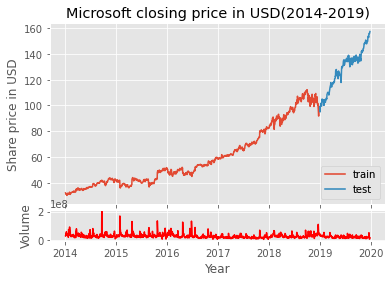

In [64]:
# Plot training and testing data 
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1,sharex=ax1)
ax1.plot( train, label='train')
ax1.plot( test, label='test')
ax2.plot(adj_close_msft_merged['Volume'],color='red')
ax1.set_title('Microsoft closing price in USD(2014-2019)')
ax1.set(ylabel='Share price in USD')
ax2.set(ylabel='Volume')
ax2.set(xlabel='Year')
leg1 = ax1.legend(loc='lower right')
ax1.add_artist(leg1)
plt.show()

In [53]:
# Daily prices including highs and lows with volume for hockeystick graph
full_msft_df = eod_msft_data[['Open','High','Low','Close','Adj_Close','Volume']].append(msft_yf)
# If a stock underwent a split, you'd have to create a new dataset based on the Adjusted Close values.
full_msft_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1507 entries, 2014-01-02 to 2019-12-27
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1507 non-null   float64
 1   High       1507 non-null   float64
 2   Low        1507 non-null   float64
 3   Close      1507 non-null   float64
 4   Adj_Close  1507 non-null   float64
 5   Volume     1507 non-null   float64
dtypes: float64(6)
memory usage: 82.4 KB


In [81]:
full_msft_df['5d-sma'] = full_msft_df['Adj_Close'].rolling(5).mean()
full_msft_df['25d-sma'] = full_msft_df['Adj_Close'].rolling(25).mean()
full_msft_df['200d-sma'] = full_msft_df['Adj_Close'].rolling(200).mean()
full_msft_df['12d-ema'] = full_msft_df['Adj_Close'].ewm(span=12, min_periods=12).mean()
full_msft_df['26d-ema'] = full_msft_df['Adj_Close'].ewm(span=26, min_periods=26).mean()
full_msft_df.head()

,Open,High,Low,Close,Adj_Close,Volume,5d-sma,25d-sma,200d-sma,12d-ema,26d-ema
Date,,,,,,,,,,,
2014-01-02,37.350,37.40,37.10,37.16,32.248064,30632200.0,NaN,NaN,NaN,NaN,NaN
2014-01-03,37.200,37.22,36.60,36.91,32.031110,31134800.0,NaN,NaN,NaN,NaN,NaN
2014-01-06,36.850,36.89,36.11,36.13,31.354213,43603700.0,NaN,NaN,NaN,NaN,NaN
2014-01-07,36.325,36.49,36.21,36.41,31.597202,35802800.0,NaN,NaN,NaN,NaN,NaN
2014-01-08,36.000,36.14,35.58,35.76,31.033121,59971700.0,31.652742,NaN,NaN,NaN,NaN


In [83]:
# Training dataset using candlestick format with rangeslider to zoom into prices in a given time period. 

fig = go.Figure(data=[go.Candlestick(x=full_msft_df.index,
                      open=full_msft_df['Open'],
                      close=full_msft_df['Close'],
                      high=full_msft_df['High'],
                      low=full_msft_df['Low'],
                      increasing_line_color='cyan',
                      decreasing_line_color='gray',
                      name='Adjusted closing price'
                     )])

fig.add_trace(
    go.Scatter(x=full_msft_df.index, y=full_msft_df["5d-sma"],mode='lines',name="Simple Moving average (5 day)")
    )
fig.add_trace(
    go.Scatter(x=full_msft_df.index, y=full_msft_df["25d-sma"],mode='lines',name="Simple Moving average (25 day)")
    )
fig.add_trace(
    go.Scatter(x=full_msft_df.index, y=full_msft_df["200d-sma"],mode='lines',name="Simple Moving average (200 day)")
    )
# fig.add_trace(
#     go.Scatter(x=full_msft_df.index, y=full_msft_df["12d-ema"],mode='lines',name="Exponential Moving average (12 day)")
#     )
# fig.add_trace(
#     go.Scatter(x=full_msft_df.index, y=full_msft_df["26d-ema"],mode='lines',name="Exponential Moving average (26 day)")
#     )
fig.update_layout(
    title='MSFT price in the last 3 years prior to 2019 as candlestick chart',
    yaxis_title='Adjusted Close Price/USD')
# Add a subplot that superimposes a moving average line plot

fig.show()



### Properties of time series


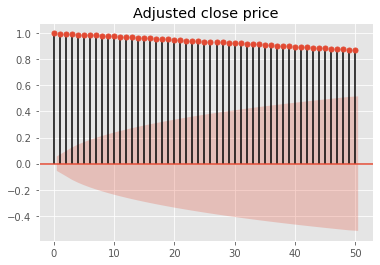

In [69]:
# PLOT ACF 
lag_acf = plot_acf(train,lags=50, title='Adjusted close price')


The height of each spike shows the value of the autocorrelation function for the lag.
<br>
The autocorrelation with lag zero always equals 1, because this represents the autocorrelation between each term and itself. Price and price with lag zero are the same variable.
<br>
Each spike that rises above or falls below the dashed lines is considered to be statistically significant.
In this example, the spikes are statistically significant for lags up to 50. This means that the MSFT stock prices are highly correlated with each other. In other words, when the price of MSFT stock rises, it tends to continue rising. When the price of MSFT stock falls, it tends to continue falling.

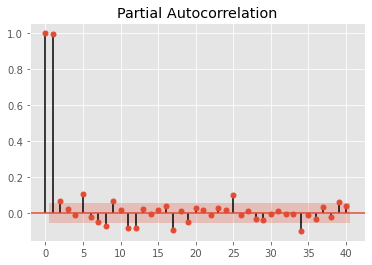

In [70]:
#PLOT PACF
lag_pacf = plot_pacf(train, lags=40)

### Testing for stationarity
<b>H0</b>: The null hypothesis: It is a statement about the population that either is believed to be true or is used to put forth an argument unless it can be shown to be incorrect beyond a reasonable doubt, ie, it is non-stationary.

<b>H1</b>: The alternative hypothesis: It is a claim about the population that is contradictory to H0 and what we conclude when we reject H0 or the time series is stationary.



In [ ]:
# test timeseries for stationarity using Dickey-Fuller test
adf_test_result = adfuller(train)
print('ADF Statistic: %f' % adf_test_result[0])
print('p-value: %f' % adf_test_result[1])
for key, value in adf_test_result[4].items():
    print('\t%s: %.3f' % (key, value))

### Decomposing a time series 
Decomposing a time series means separating it into its constituent components, which are usually a trend component and an irregular component, and if it is a seasonal time series, a seasonal component.
To estimate the trend component of a non-seasonal time series that can be described using an additive model, it is common to use a smoothing method, such as calculating the simple moving average of the time series.

Here, the p-value (0.97) is greater than 0.05 so we cannot reject the Null hypothesis and has a unit root. And that the series has some time dependent features as well. 
For time series analysis, we will need to separate trend and seasonality from the time series.

In [ ]:
# Attempt to transform the series 
# train_tf = np.log(train)
# Series differencing  
train_first_diff = train.values[1:] - train.values[:-1]
train_first_diff = np.concatenate(train_first_diff,[0])

# Test to see stationarity again
# adf_test_result = adfuller(diff_train_tf)
# print('ADF Statistic: %f' % adf_test_result[0])
# print('p-value: %f' % adf_test_result[1])
# for key, value in adf_test_result[4].items():
#     print('\t%s: %.3f' % (key, value))

In [ ]:
plot_pacf(diff_train_tf,lags=50)

### Building the ARIMA model 
Auto-Regressive (p) -> Number of autoregressive terms. 
<br>
Integrated (d) -> Number of nonseasonal differences needed for stationarity.
<br>
Moving Average (q) -> Number of lagged forecast errors in the prediction equation.
<br>
In the Auto-ARIMA model, note that small p,d,q values represent non-seasonal components, and capital P, D, Q represent seasonal components. It works similarly like hyperparameter tuning techniques to find the optimal value of p, d, and q with different combinations and the final values would be determined with the lower AIC, BIC parameters taking into consideration.
<br>
Here, we are trying with the p, d, q values ranging from 0 to 5 to get better optimal values from the model.

In [ ]:
arima_model = auto_arima(train_tf,m=12)
#  determine the optimal order for the timeseries for an ARIMA model.

In [ ]:
print(arima_model)

Using the auto_arima function, we have determined the parameters that would be able to describe the nature of our timeseries. 
According the function, the timeseries will require a <b>0th order moving average model</b> or MA(0)